In [295]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [296]:
bank = pd.read_csv('bank_transactions.csv')
bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [297]:
from datetime import datetime, date

bank['TransactionDate'] = pd.to_datetime(bank['TransactionDate'], format='mixed')
bank['TransactionDate'] = bank['TransactionDate'].apply(lambda x: x - pd.DateOffset(years=100) if x > datetime.now() else x)

In [298]:
bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2016-02-08,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2016-02-08,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5


In [299]:
bank['TransactionYear'] = bank['TransactionDate'].dt.year
bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionYear
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,2016
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0,2016
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2016-02-08,142712,459.0,2016
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2016-02-08,142714,2060.0,2016
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5,2016


In [300]:
bank['CustomerDOB'] = pd.to_datetime(bank['CustomerDOB'], format='mixed')
bank['CustomerDOB'] = bank['CustomerDOB'].apply(lambda x: x - pd.DateOffset(years=100) if x > datetime.now() else x)
bank['CustomerYear'] = bank['CustomerDOB'].dt.year
bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionYear,CustomerYear
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,2016,1994.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0,2016,1957.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0,2016,1996.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0,2016,1973.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5,2016,1988.0


In [301]:
bank['CustomerAge'] = bank['TransactionYear'] - bank['CustomerYear']
bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionYear,CustomerYear,CustomerAge
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,2016,1994.0,22.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0,2016,1957.0,59.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0,2016,1996.0,20.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0,2016,1973.0,43.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5,2016,1988.0,28.0


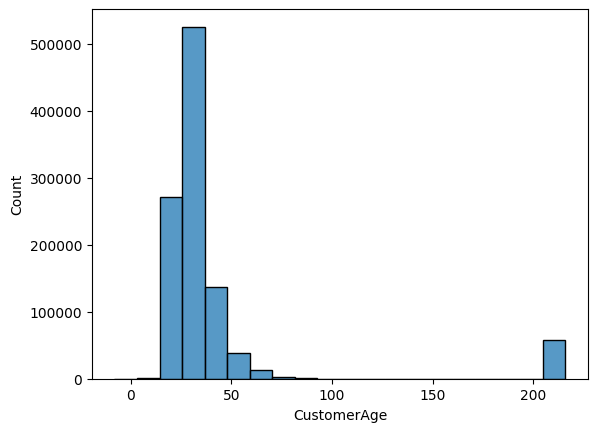

In [302]:
sns.histplot(data=bank,x='CustomerAge',bins=20)
plt.show()

In [303]:
bank = bank[bank.CustomerAge < 100]
bank = bank[bank.CustomerAge > 0]

bank.head()


,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionYear,CustomerYear,CustomerAge
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,2016,1994.0,22.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0,2016,1957.0,59.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0,2016,1996.0,20.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0,2016,1973.0,43.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5,2016,1988.0,28.0


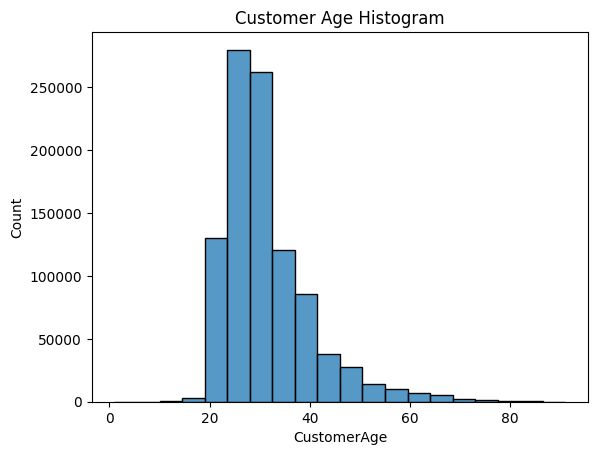

In [304]:
sns.histplot(data=bank,x='CustomerAge',bins=20)
plt.title('Customer Age Histogram')
plt.show()

In [305]:
bank = bank[(bank['CustAccountBalance'] - bank['TransactionAmount (INR)']) > 0]

In [306]:
bank.isna().sum()

TransactionID                0
CustomerID                   0
CustomerDOB                  0
CustGender                 135
CustLocation               140
CustAccountBalance           0
TransactionDate              0
TransactionTime              0
TransactionAmount (INR)      0
TransactionYear              0
CustomerYear                 0
CustomerAge                  0
dtype: int64

In [307]:
bank = bank.dropna()

In [308]:
bank['TransactionDate'].min()

Timestamp('2016-01-08 00:00:00')

In [309]:
bank['TransactionDate'].max()

Timestamp('2016-12-09 00:00:00')

In [310]:
today_date = datetime(2017, 1, 1)

bank['Recency'] = (today_date - bank['TransactionDate']).dt.days
bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionYear,CustomerYear,CustomerAge,Recency
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,2016,1994.0,22.0,328
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0,2016,1996.0,20.0,328
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0,2016,1973.0,43.0,328
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5,2016,1988.0,28.0,328
5,T6,C1536588,1972-08-10,F,ITANAGAR,53609.20,2016-02-08,173940,676.0,2016,1972.0,44.0,328


In [311]:
bank['TotalTransactionAmount'] = bank.groupby('CustomerID')['TransactionAmount (INR)'].transform('sum')
bank['MedianTransactionAmount'] = bank.groupby('CustomerID')['TransactionAmount (INR)'].transform('median')
bank['AvgTransactionAmount'] = bank['TotalTransactionAmount'] / bank.groupby('CustomerID')['TransactionID'].transform('nunique')

bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionYear,CustomerYear,CustomerAge,Recency,TotalTransactionAmount,MedianTransactionAmount,AvgTransactionAmount
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0,2016,1994.0,22.0,328,25.0,25.0,25.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0,2016,1996.0,20.0,328,459.0,459.0,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0,2016,1973.0,43.0,328,2938.4,1469.2,1469.2
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5,2016,1988.0,28.0,328,1762.5,1762.5,1762.5
5,T6,C1536588,1972-08-10,F,ITANAGAR,53609.20,2016-02-08,173940,676.0,2016,1972.0,44.0,328,676.0,676.0,676.0


In [312]:
bank = bank.sort_values(by=['CustomerID', 'TransactionDate'])
bank['TransactionCountUpToDate'] = bank.groupby('CustomerID').cumcount() + 1

bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionYear,CustomerYear,CustomerAge,Recency,TotalTransactionAmount,MedianTransactionAmount,AvgTransactionAmount,TransactionCountUpToDate
173508,T173509,C1010011,1983-05-08,M,NEW DELHI,120180.54,2016-09-08,11229,356.0,2016,1983.0,33.0,115,5106.0,2553.0,2553.0,1
33670,T33671,C1010011,1992-08-19,F,NOIDA,32500.73,2016-09-26,123813,4750.0,2016,1992.0,24.0,97,5106.0,2553.0,2553.0,2
363021,T363022,C1010012,1994-07-28,M,MUMBAI,24204.49,2016-08-14,204409,1499.0,2016,1994.0,22.0,140,1499.0,1499.0,1499.0,1
89543,T89544,C1010014,1992-04-06,F,MUMBAI,38377.14,2016-01-08,154451,1205.0,2016,1992.0,24.0,359,1455.0,727.5,727.5,1
251647,T251648,C1010014,1984-08-19,M,MUMBAI,161848.76,2016-07-08,220305,250.0,2016,1984.0,32.0,177,1455.0,727.5,727.5,2


In [313]:
bank['TransactionCount'] = bank.groupby('CustomerID')['TransactionID'].transform('count')
bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionYear,CustomerYear,CustomerAge,Recency,TotalTransactionAmount,MedianTransactionAmount,AvgTransactionAmount,TransactionCountUpToDate,TransactionCount
173508,T173509,C1010011,1983-05-08,M,NEW DELHI,120180.54,2016-09-08,11229,356.0,2016,1983.0,33.0,115,5106.0,2553.0,2553.0,1,2
33670,T33671,C1010011,1992-08-19,F,NOIDA,32500.73,2016-09-26,123813,4750.0,2016,1992.0,24.0,97,5106.0,2553.0,2553.0,2,2
363021,T363022,C1010012,1994-07-28,M,MUMBAI,24204.49,2016-08-14,204409,1499.0,2016,1994.0,22.0,140,1499.0,1499.0,1499.0,1,1
89543,T89544,C1010014,1992-04-06,F,MUMBAI,38377.14,2016-01-08,154451,1205.0,2016,1992.0,24.0,359,1455.0,727.5,727.5,1,2
251647,T251648,C1010014,1984-08-19,M,MUMBAI,161848.76,2016-07-08,220305,250.0,2016,1984.0,32.0,177,1455.0,727.5,727.5,2,2


In [314]:
bank['TransactionYearMonth'] = bank['TransactionDate'].dt.to_period('M')

monthly_frequency = bank.groupby(['CustomerID', 'TransactionYearMonth'])['TransactionID'].count().reset_index()
monthly_frequency['MonthlyFrequency'] = monthly_frequency.groupby('CustomerID')['TransactionID'].transform('sum')

bank = bank.merge(monthly_frequency[['CustomerID', 'MonthlyFrequency']], on='CustomerID', how='left')
bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionYear,CustomerYear,CustomerAge,Recency,TotalTransactionAmount,MedianTransactionAmount,AvgTransactionAmount,TransactionCountUpToDate,TransactionCount,TransactionYearMonth,MonthlyFrequency
0,T173509,C1010011,1983-05-08,M,NEW DELHI,120180.54,2016-09-08,11229,356.0,2016,1983.0,33.0,115,5106.0,2553.0,2553.0,1,2,2016-09,2
1,T33671,C1010011,1992-08-19,F,NOIDA,32500.73,2016-09-26,123813,4750.0,2016,1992.0,24.0,97,5106.0,2553.0,2553.0,2,2,2016-09,2
2,T363022,C1010012,1994-07-28,M,MUMBAI,24204.49,2016-08-14,204409,1499.0,2016,1994.0,22.0,140,1499.0,1499.0,1499.0,1,1,2016-08,1
3,T89544,C1010014,1992-04-06,F,MUMBAI,38377.14,2016-01-08,154451,1205.0,2016,1992.0,24.0,359,1455.0,727.5,727.5,1,2,2016-01,2
4,T89544,C1010014,1992-04-06,F,MUMBAI,38377.14,2016-01-08,154451,1205.0,2016,1992.0,24.0,359,1455.0,727.5,727.5,1,2,2016-01,2


In [315]:
yearly_frequency = bank.groupby(['CustomerID', 'TransactionYear'])['TransactionID'].count().reset_index()
yearly_frequency['YearlyFrequency'] = yearly_frequency.groupby('CustomerID')['TransactionID'].transform('sum')

bank = bank.merge(yearly_frequency[['CustomerID', 'YearlyFrequency']], on='CustomerID', how='left')
bank.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionYear,...,CustomerAge,Recency,TotalTransactionAmount,MedianTransactionAmount,AvgTransactionAmount,TransactionCountUpToDate,TransactionCount,TransactionYearMonth,MonthlyFrequency,YearlyFrequency
0,T173509,C1010011,1983-05-08,M,NEW DELHI,120180.54,2016-09-08,11229,356.0,2016,...,33.0,115,5106.0,2553.0,2553.0,1,2,2016-09,2,2
1,T33671,C1010011,1992-08-19,F,NOIDA,32500.73,2016-09-26,123813,4750.0,2016,...,24.0,97,5106.0,2553.0,2553.0,2,2,2016-09,2,2
2,T363022,C1010012,1994-07-28,M,MUMBAI,24204.49,2016-08-14,204409,1499.0,2016,...,22.0,140,1499.0,1499.0,1499.0,1,1,2016-08,1,1
3,T89544,C1010014,1992-04-06,F,MUMBAI,38377.14,2016-01-08,154451,1205.0,2016,...,24.0,359,1455.0,727.5,727.5,1,2,2016-01,2,4
4,T89544,C1010014,1992-04-06,F,MUMBAI,38377.14,2016-01-08,154451,1205.0,2016,...,24.0,359,1455.0,727.5,727.5,1,2,2016-01,2,4


In [316]:
bank.drop(columns=['TransactionID', 'CustomerID', 'TransactionDate', 'TransactionTime', 'CustomerDOB', 'CustomerYear', 'TransactionYearMonth', 'TransactionYear', 'CustLocation'], axis=1, inplace=True)
bank.head()

,CustGender,CustAccountBalance,TransactionAmount (INR),CustomerAge,Recency,TotalTransactionAmount,MedianTransactionAmount,AvgTransactionAmount,TransactionCountUpToDate,TransactionCount,MonthlyFrequency,YearlyFrequency
0,M,120180.54,356.0,33.0,115,5106.0,2553.0,2553.0,1,2,2,2
1,F,32500.73,4750.0,24.0,97,5106.0,2553.0,2553.0,2,2,2,2
2,M,24204.49,1499.0,22.0,140,1499.0,1499.0,1499.0,1,1,1,1
3,F,38377.14,1205.0,24.0,359,1455.0,727.5,727.5,1,2,2,4
4,F,38377.14,1205.0,24.0,359,1455.0,727.5,727.5,1,2,2,4


In [317]:
bank.isna().sum()

CustGender                  0
CustAccountBalance          0
TransactionAmount (INR)     0
CustomerAge                 0
Recency                     0
TotalTransactionAmount      0
MedianTransactionAmount     0
AvgTransactionAmount        0
TransactionCountUpToDate    0
TransactionCount            0
MonthlyFrequency            0
YearlyFrequency             0
dtype: int64

In [318]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = make_pipeline(StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder())

num_attribs = ['CustAccountBalance','TransactionAmount (INR)','CustomerAge', 'Recency', 'TotalTransactionAmount','AvgTransactionAmount', 'TransactionCountUpToDate', 'TransactionCount', 'MonthlyFrequency', 'YearlyFrequency']
cat_attribs = ['CustGender']

preprocessing = ColumnTransformer([
    ('num',num_pipeline,num_attribs),
    ('cat',cat_pipeline,cat_attribs)
])

bank_scaled = preprocessing.fit_transform(bank)

In [319]:
from sklearn.decomposition import TruncatedSVD

bank_pca = TruncatedSVD(n_components=11)
bank_pca.fit(bank_scaled)

bank_transformed = bank_pca.transform(bank_scaled)

In [320]:
from sklearn.cluster import KMeans

cluster = list(range(1,21))
inertias = []

for clusters in cluster:
    kmeans_bank = KMeans(n_clusters=clusters,n_init='auto',random_state=42)
    kmeans_bank.fit(bank_transformed)
    inertias.append(kmeans_bank.inertia_)

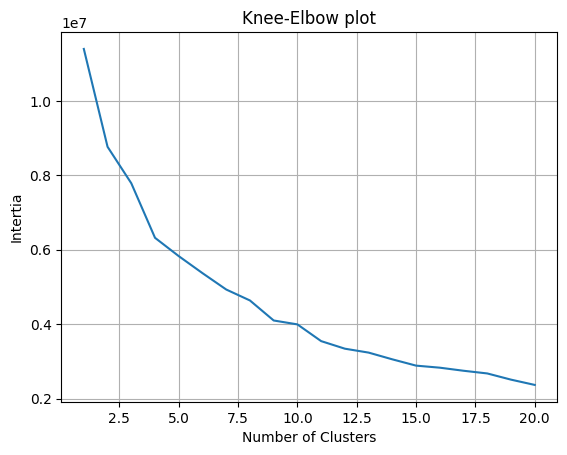

In [321]:
plt.plot(cluster,inertias)
plt.xlabel('Number of Clusters')
plt.ylabel('Intertia')
plt.title('Knee-Elbow plot')
plt.grid()
plt.show()

In [322]:
kmeans_chosen = KMeans(n_clusters=4,n_init='auto',random_state=42)
kmeans_chosen.fit(bank_transformed)

bank['Labels'] = kmeans_chosen.labels_
bank['Labels'].value_counts()

Labels
3    657095
2    350960
1     81640
0      5907
Name: count, dtype: int64

In [333]:
labels = [0,1,2,3]

for label in labels:
    df_cluster = bank[bank.Labels == label]
    mode_gender = df_cluster['CustGender'].mode()
    mean_accountbalance = df_cluster['CustAccountBalance'].mean()
    mean_transaction_amt = df_cluster['TransactionAmount (INR)'].mean()
    mean_customer_age = df_cluster['CustomerAge'].mean()
    avg_transaction_values = df_cluster['AvgTransactionAmount'].mean()

    monthly_frequency = df_cluster['MonthlyFrequency'].mean()
    yearly_frequency = df_cluster['YearlyFrequency'].mean()


    print(f'Cluster no: {label}')
    print(f'Mean Account Balance: {round(mean_accountbalance)}')
    print(f'Mean Transaction Amount: {round(mean_transaction_amt)}')
    print(f'Mean Avg Transaction Value: {round(avg_transaction_values)}')
    print(f'Mean Monthly Transaction: {round(monthly_frequency, 4)}')
    print(f'Mean Yearly Transaction: {round(yearly_frequency, 4)}')
    print(f'Mean Customer Age: {round(mean_customer_age)}\n')


Cluster no: 0
Mean Account Balance: 1297990
Mean Transaction Amount: 40863
Mean Avg Transaction Value: 37955
Mean Monthly Transaction: 1.4608
Mean Yearly Transaction: 2.3536
Mean Customer Age: 38

Cluster no: 1
Mean Account Balance: 112132
Mean Transaction Amount: 1109
Mean Avg Transaction Value: 1173
Mean Monthly Transaction: 3.1628
Mean Yearly Transaction: 8.918
Mean Customer Age: 31

Cluster no: 2
Mean Account Balance: 112714
Mean Transaction Amount: 1073
Mean Avg Transaction Value: 1107
Mean Monthly Transaction: 2.0288
Mean Yearly Transaction: 3.821
Mean Customer Age: 31

Cluster no: 3
Mean Account Balance: 110341
Mean Transaction Amount: 1039
Mean Avg Transaction Value: 1039
Mean Monthly Transaction: 1.0
Mean Yearly Transaction: 1.0
Mean Customer Age: 31



## Cluster Summary

The customer transaction data is divided into four clusters based on key metrics such as account balance, transaction amounts, transaction frequency, and customer age. Below is a generalized summary of each cluster:

### Cluster 0: High Account Balance, Infrequent High-Value Transactions
- **Profile**: Customers with significantly high account balances who make infrequent but large-value transactions.
- **Key Characteristics**: 
  - High account balance (INR 1.3M)
  - Large transaction amounts (INR 40,863)
  - Low transaction frequency (1.46 monthly transactions)
  - Average customer age of 38 years

### Cluster 1: Moderate Account Balance, Frequent Moderate-Value Transactions
- **Profile**: Customers with moderate account balances who engage in more frequent, moderate-value transactions.
- **Key Characteristics**: 
  - Moderate account balance (INR 112K)
  - Moderate transaction amounts (INR 1,109)
  - Higher transaction frequency (3.16 monthly transactions)
  - Average customer age of 31 years

### Cluster 2: Low Account Balance, Moderate Transaction Frequency
- **Profile**: Customers with low account balances who make moderate-value transactions with moderate frequency.
- **Key Characteristics**: 
  - Low account balance (INR 112K)
  - Low transaction amounts (INR 1,073)
  - Moderate transaction frequency (2.03 monthly transactions)
  - Average customer age of 31 years

### Cluster 3: Low Account Balance, Infrequent Low-Value Transactions
- **Profile**: Customers with low account balances who make infrequent, small-value transactions.
- **Key Characteristics**: 
  - Low account balance (INR 110K)
  - Small transaction amounts (INR 1,039)
  - Low transaction frequency (1 monthly transaction)
  - Average customer age of 31 years

### General Insights
- **High-Value Customers**: Cluster 0 represents premium customers with high account balances but low transaction frequency.
- **Frequent, Moderate-Spending Customers**: Cluster 1 consists of customers with moderate balances who make regular purchases.
- **Low-Spending, Moderate Frequency**: Cluster 2 shows customers with low balances who make moderate-value transactions.
- **Low-Spending, Infrequent Customers**: Cluster 3 contains customers who spend small amounts with minimal transaction frequency.

These clusters help identify customer segments with different spending behaviors, account balances, and engagement patterns, enabling businesses to tailor marketing and retention strategies.
